# 1. Install Dependencies and Setup

In [114]:
import tensorflow as tf
import os

In [115]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [116]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove unwanted images

In [117]:
import cv2
import imghdr

In [118]:
data_dir = 'data' 

In [119]:
os.listdir('data')

['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

In [120]:
image_exts = ['jpeg','png', 'bmp', 'jpg']

In [121]:
from PIL import Image
import os

def convert_jpg_to_jpeg(file_path):

    with Image.open(file_path) as img:
        # Define the new file path with .jpeg extension
        new_file_path = os.path.splitext(file_path)[0] + '.jpeg'
        
        # Save the image in JPEG format
        img.convert('RGB').save(new_file_path, 'JPEG')
        
        # Optionally, remove the original .jpg file
        os.remove(file_path)
        
        print(f"Converted {file_path} to {new_file_path}")


In [122]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            tip = image_path.split(".")[-1].lower()
            if tip == 'jpg':
                convert_jpg_to_jpeg(image_path)
                
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
                print("removed")
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [123]:
import numpy as np
from matplotlib import pyplot as plt

In [124]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)
Source:   
@keras_export(
    [
        "keras.utils.image_dataset_from_directory",
        "keras.preprocessing.image_dataset_from_directory",
    ]
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    ve

In [125]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 2152 files belonging to 3 classes.


In [126]:
len(data)

68

In [127]:
class_names = data.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [128]:
#converting our data inoto a iteratior to access it by batches of 32 image and their labels
data_iterator = data.as_numpy_iterator()

In [129]:
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x000001F3BE3AFBF0>)

In [130]:
batch = data_iterator.next()
batch[0].shape

(32, 256, 256, 3)

Each batch contain, 32 images as numpy array respahed into 256x256x3 format and their labels.

In [132]:
batch[1]

array([0, 1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 2, 0])

Lets check which label is assigned to which type of image

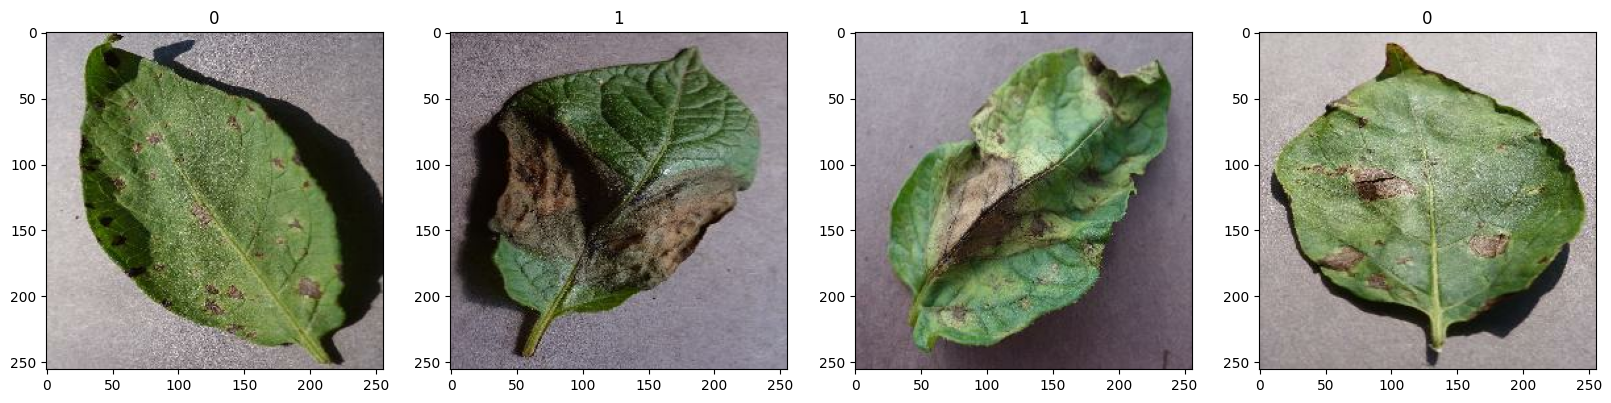

In [133]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][0:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

So we can clearly see that- 

- Label 0 is for Happy images
- Lavel 1 is for sad images

# 4. Normalizing Data

In [134]:
data_scaled = data.map(lambda x,y: (x/255, y))

In [135]:
data_scaled.as_numpy_iterator().next()

(array([[[[0.5803922 , 0.5568628 , 0.59607846],
          [0.5921569 , 0.5686275 , 0.60784316],
          [0.654902  , 0.63529414, 0.6627451 ],
          ...,
          [0.74509805, 0.73333335, 0.7607843 ],
          [0.7372549 , 0.7254902 , 0.7529412 ],
          [0.7294118 , 0.7176471 , 0.74509805]],
 
         [[0.6862745 , 0.6627451 , 0.7019608 ],
          [0.67058825, 0.64705884, 0.6862745 ],
          [0.6666667 , 0.64705884, 0.6745098 ],
          ...,
          [0.74509805, 0.73333335, 0.7607843 ],
          [0.7411765 , 0.7294118 , 0.75686276],
          [0.7372549 , 0.7254902 , 0.7529412 ]],
 
         [[0.6745098 , 0.6509804 , 0.6901961 ],
          [0.65882355, 0.63529414, 0.6745098 ],
          [0.61960787, 0.6       , 0.627451  ],
          ...,
          [0.74509805, 0.73333335, 0.7607843 ],
          [0.7490196 , 0.7372549 , 0.7647059 ],
          [0.74509805, 0.73333335, 0.7607843 ]],
 
         ...,
 
         [[0.5647059 , 0.5647059 , 0.59607846],
          [0.61568

# 5. Split Data

In [136]:
'''
# Load the dataset from a directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    'path_to_your_directory',  # Path to the main directory containing subdirectories of images
    image_size=(224, 224),     # Resize all images to this size
    batch_size=32,             # Number of images per batch
    shuffle=True,              # Shuffle the dataset
    validation_split=0.3,      # Split 30% of the data for validation
    subset='training',         # Specify whether this is the training subset
    seed=123                   # Random seed for reproducibility
)

# For validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    'path_to_your_directory',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    validation_split=0.3,
    subset='validation',
    seed=123
)
'''

"\n# Load the dataset from a directory\ntrain_dataset = tf.keras.utils.image_dataset_from_directory(\n    'path_to_your_directory',  # Path to the main directory containing subdirectories of images\n    image_size=(224, 224),     # Resize all images to this size\n    batch_size=32,             # Number of images per batch\n    shuffle=True,              # Shuffle the dataset\n    validation_split=0.3,      # Split 30% of the data for validation\n    subset='training',         # Specify whether this is the training subset\n    seed=123                   # Random seed for reproducibility\n)\n\n# For validation dataset\nvalidation_dataset = tf.keras.utils.image_dataset_from_directory(\n    'path_to_your_directory',\n    image_size=(224, 224),\n    batch_size=32,\n    shuffle=True,\n    validation_split=0.3,\n    subset='validation',\n    seed=123\n)\n"

In [137]:
# length of data in batches

len(data_scaled)

68

In [138]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

In [139]:
train_size, test_size, val_size

(47, 6, 13)

In [140]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [141]:
len(train), len(val), len(test)

(47, 13, 6)

# 6. Build Deep Learning Model

In [142]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [143]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import layers


In [144]:
output_units = len(os.listdir('data'))

In [145]:
data_augmentation = tf.keras.Sequential([
    
    layers.RandomFlip("horizontal_and_vertical"),  # Flip horizontally and vertically
    layers.RandomRotation(0.2),                    # Rotate by up to 20%
    layers.RandomZoom(0.2),                        # Zoom in by up to 20%
    layers.RandomContrast(0.2),                    # Adjust contrast by up to 20%
])

output_units = len(os.listdir('data')) #numbner of labels in our data

train = train.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [146]:
len(train)

47

In [147]:
model = Sequential([
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(256,256,3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(output_units, activation='softmax'),
])

d:\projects\Potato Disease Classifier\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [148]:
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [149]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [150]:
logdir='logs'

In [151]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [152]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.4796 - loss: 2.7416 - val_accuracy: 0.5312 - val_loss: 0.7863
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6600 - loss: 0.7026 - val_accuracy: 0.8173 - val_loss: 0.4242
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7397 - loss: 0.5533 - val_accuracy: 0.8726 - val_loss: 0.3399
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8564 - loss: 0.3465 - val_accuracy: 0.8846 - val_loss: 0.2653
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8419 - loss: 0.3484 - val_accuracy: 0.8990 - val_loss: 0.2490
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8802 - loss: 0.2965 - val_accuracy: 0.9495 - val_loss: 0.1614
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9102 - loss: 0.2321 - val_accuracy: 0.6490 - val_loss: 0.9885
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8924 - loss: 0.2736 - val_accuracy: 0.6562 - val_loss:

# 8. Plot Performance

In [153]:
hist.history

{'accuracy': [0.5132978558540344,
  0.6835106611251831,
  0.779920220375061,
  0.8331117033958435,
  0.8656914830207825,
  0.883643627166748,
  0.9069148898124695,
  0.8956117033958435,
  0.886303186416626,
  0.897606372833252,
  0.8889627456665039,
  0.8996010422706604,
  0.927526593208313,
  0.9222074747085571,
  0.8929521441459656,
  0.8936170339584351,
  0.9501329660415649,
  0.9507978558540344,
  0.947473406791687,
  0.958776593208313],
 'loss': [1.4707677364349365,
  0.6590810418128967,
  0.48589640855789185,
  0.3813287913799286,
  0.32016050815582275,
  0.28395676612854004,
  0.23488712310791016,
  0.2718298137187958,
  0.2888219654560089,
  0.26517170667648315,
  0.27398887276649475,
  0.2524645924568176,
  0.1716485172510147,
  0.20400507748126984,
  0.2870807945728302,
  0.2571263313293457,
  0.12820976972579956,
  0.14152461290359497,
  0.12696725130081177,
  0.11774284392595291],
 'val_accuracy': [0.53125,
  0.817307710647583,
  0.8725961446762085,
  0.8846153616905212,
  

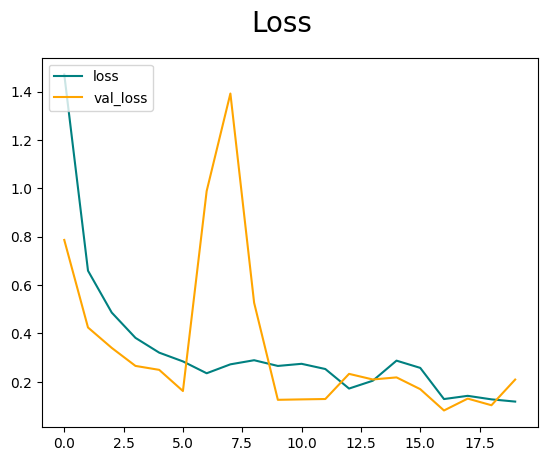

In [154]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

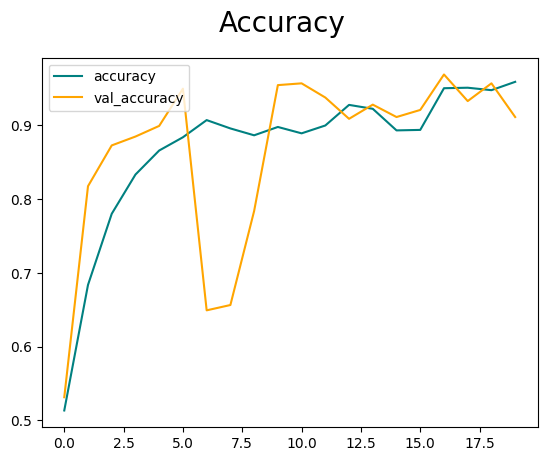

In [155]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [156]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [157]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [158]:
len(test)

6

In [159]:
len(test)

6

In [160]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pred = []
    for ypred in yhat:
        pred.append(np.argmax(ypred))
    ped = np.array(pred)
    pre.update_state(y, pred)
    re.update_state(y, pred)
    acc.update_state(y, pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


In [161]:
print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

1.0 0.9361702 0.9114583


In [162]:
print(pred)

[0, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 2, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0, 1, 1, 0, 0, 1, 1]


# 10. Test

In [163]:
import cv2

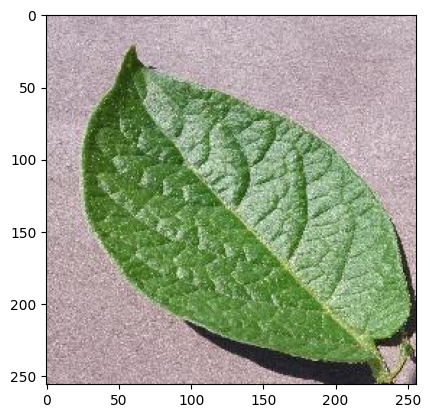

In [165]:
#cv2 imagwe are in BGR not in RGB color format so we need to change it if you want to see it properly

img = cv2.imread(r"data\Potato___healthy\1ae826e2-5148-47bd-a44c-711ec9cc9c75___RS_HL 1954.jpeg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

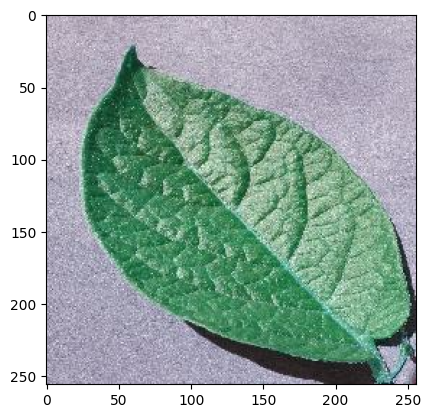

In [166]:
#resizeing our image to match the input of model
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [167]:
resize.shape

TensorShape([256, 256, 3])

In [168]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

We need to give our image as a batch of 1 image so for it we will add one more dimension to our image

In [169]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


In [170]:
yhat

array([[0.26487532, 0.44313997, 0.2919847 ]], dtype=float32)

In [171]:
labels = os.listdir('data')

In [172]:
index = np.argmax(yhat.reshape(-1))

In [173]:
print(f"Prediction is {labels[index]}")

Prediction is Potato___healthy


# 11. Save the Model

In [174]:
from tensorflow.keras.models import load_model

In [175]:
model.save(os.path.join('models','model_notebook.keras'))

In [177]:
new_model = load_model("models/model_notebook.keras")

In [178]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


array([[0.26487532, 0.44313997, 0.2919847 ]], dtype=float32)